In [64]:
from qnet_context import qnetvo as qnet
from mac_context import multiple_access_channels as mac
import matplotlib.pyplot as plt

import numpy as np

from os import listdir
from os.path import isfile, join
import re

# Loading Data


In [65]:
def get_data_files(path, regex):
    """Retrieves all data files that match the ``regex`` in the
    directory specified by ``path``.
    """
    return [
        join(path, f)
        for f in listdir(path)
        if (f.endswith(".json") and isfile(join(path, f)) and bool(re.match(regex, f)))
    ]

In [79]:
data_path = "../data/bisender_mac_quantum_violations/"
qmac_regex = r"qmac_"
ea_mac_regex = r"ea_mac_"
and_tag = r"and_"
xor_tag = r"xor_"

qmac_xor_opt_dicts = []
qmac_and_opt_dicts = []
ea_mac_xor_opt_dicts =[]
ea_mac_and_opt_dicts = []

for i in range(20):
    inequality_tag = "I_fp_" if i == 0 else "I_" + str(i) + "_"
    
    qmac_xor_regex = qmac_regex + inequality_tag + xor_tag + r".*"    
    qmac_xor_files = get_data_files(data_path, qmac_xor_regex)
    qmac_xor_opt_dicts += [[qnet.read_optimization_json(file) for file in qmac_xor_files]]
    
    qmac_and_regex = qmac_regex + inequality_tag + and_tag + r".*"    
    qmac_and_files = get_data_files(data_path, qmac_and_regex)
    qmac_and_opt_dicts += [[qnet.read_optimization_json(file) for file in qmac_and_files]]

    
    ea_mac_xor_regex = ea_mac_regex + inequality_tag + xor_tag + r".*"  
    ea_mac_xor_files = get_data_files(data_path, ea_mac_xor_regex)
    ea_mac_xor_opt_dicts += [[qnet.read_optimization_json(file) for file in ea_mac_xor_files]]

    
    ea_mac_and_regex = ea_mac_regex + inequality_tag + and_tag + r".*"  
    ea_mac_and_files = get_data_files(data_path, ea_mac_and_regex)
    ea_mac_and_opt_dicts += [[qnet.read_optimization_json(file) for file in ea_mac_and_files]]


## Analyzing Data

In [80]:
qmac_xor_max_violations = []
qmac_and_max_violations = []
ea_mac_xor_max_violations = []
ea_mac_and_max_violations = []

classical_bounds = [7]
classical_bounds += [inequality_tuple[0] for inequality_tuple in mac.bisender_mac_bounds()]

# for i in range(20):
for i in range(15):
    qmac_xor_max_violations += [
        max([opt_dict["opt_score"] for opt_dict in qmac_xor_opt_dicts[i]]) - classical_bounds[i]
    ]
    qmac_and_max_violations += [
        max([opt_dict["opt_score"] for opt_dict in qmac_and_opt_dicts[i]]) - classical_bounds[i]
    ]

    ea_mac_xor_max_violations += [
        max([opt_dict["opt_score"] for opt_dict in ea_mac_xor_opt_dicts[i]]) - classical_bounds[i]
    ]
    ea_mac_and_max_violations += [
        max([opt_dict["opt_score"] for opt_dict in ea_mac_and_opt_dicts[i]]) - classical_bounds[i]
    ]
    

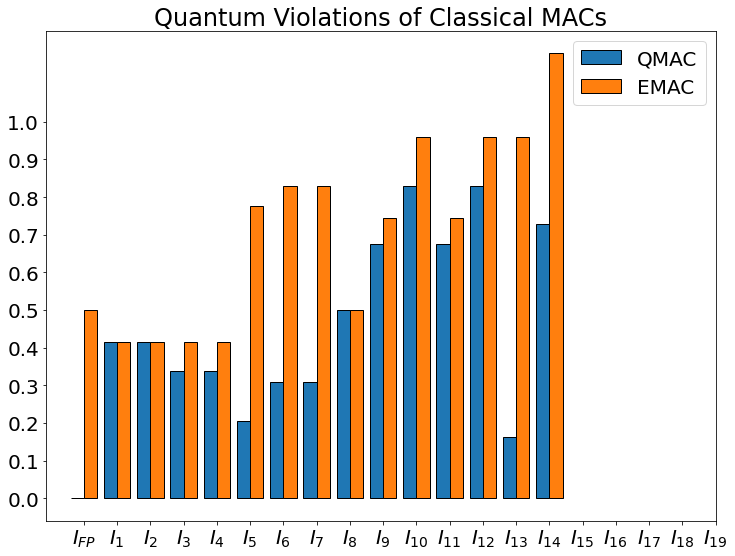

In [81]:
x_labels = [
    r"$I_{FP}$", r"$I_1$", r"$I_2$",r"$I_3$", r"$I_4$", r"$I_5$", r"$I_6$", r"$I_7$", r"$I_8$", r"$I_9$", r"$I_{10}$",
    r"$I_{11}$", r"$I_{12}$",r"$I_{13}$", r"$I_{14}$", r"$I_{15}$", r"$I_{16}$", r"$I_{17}$", r"$I_{18}$", r"$I_{19}$",
]

x_axis = np.arange(20)

plt.figure(figsize=(12, 9))

plt.bar(x_axis[0:15]-0.2, qmac_xor_max_violations[0:15], width=0.4, label="QMAC", edgecolor="black")
plt.bar(x_axis[0:15]+0.2, ea_mac_xor_max_violations[0:15], width=0.4, label="EMAC", edgecolor="black")

plt.xticks(x_axis, x_labels, fontsize=20)
plt.title("Quantum Violations of Classical MACs", size=24)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],fontsize=20)
plt.legend(fontsize=20)

plt.show()

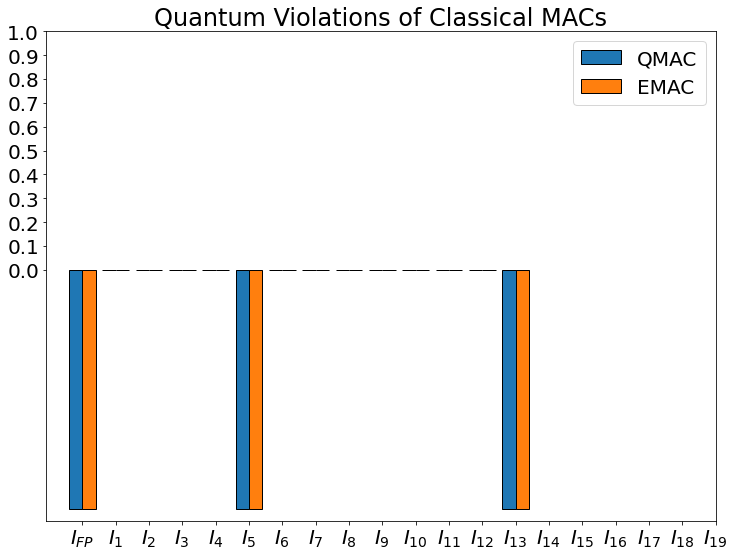

In [82]:
x_labels = [
    r"$I_{FP}$", r"$I_1$", r"$I_2$",r"$I_3$", r"$I_4$", r"$I_5$", r"$I_6$", r"$I_7$", r"$I_8$", r"$I_9$", r"$I_{10}$",
    r"$I_{11}$", r"$I_{12}$",r"$I_{13}$", r"$I_{14}$", r"$I_{15}$", r"$I_{16}$", r"$I_{17}$", r"$I_{18}$", r"$I_{19}$",
]

x_axis = np.arange(20)

plt.figure(figsize=(12, 9))

plt.bar(x_axis[0:14]-0.2, qmac_and_max_violations[0:14], width=0.4, label="QMAC", edgecolor="black")
plt.bar(x_axis[0:14]+0.2, ea_mac_and_max_violations[0:14], width=0.4, label="EMAC", edgecolor="black")

plt.xticks(x_axis, x_labels, fontsize=20)
plt.title("Quantum Violations of Classical MACs", size=24)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],fontsize=20)
plt.legend(fontsize=20)

plt.show()